# Chapter 5. Fine-tuning Large Language Models

## 5.4 Implementation of natural language inference, semantic similarity calculation, and multiple choice question answering models

### 5.4.1 Natural Language Inference

#### Preparing the Environment

In [1]:
!pip -q install transformers[ja,torch] datasets matplotlib japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 37.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 71.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [2]:
from transformers.trainer_utils import set_seed

# Fixed random number seed to 42
set_seed(42)

#### Preparing the Dataset

In [3]:
from pprint import pprint
from datasets import load_dataset

# Load the JNLI data from the llm-book/JGLUE repository on Hugging Face Hub
train_dataset = load_dataset(
    "llm-book/JGLUE", name="JNLI", split="train"
)
valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JNLI", split="validation"
)
# Display in a readable format using pprint
pprint(train_dataset[0])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

{'label': 2,
 'sentence1': '二人の男性がジャンボジェット機を見ています。',
 'sentence2': '2人の男性が、白い飛行機を眺めています。',
 'sentence_pair_id': '0',
 'yjcaptions_id': '100124-104404-104405'}


In [4]:
pprint(train_dataset.features)

{'label': ClassLabel(names=['entailment', 'contradiction', 'neutral'], id=None),
 'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'sentence_pair_id': Value(dtype='string', id=None),
 'yjcaptions_id': Value(dtype='string', id=None)}


#### Tokenizer

In [5]:
from transformers import AutoTokenizer

# Specify the model name on Hugging Face Hub
model_name = "cl-tohoku/bert-base-japanese-v3"
# Load the tokenizer from the model name
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

#### Visualizing Dataset Statistics

100%|██████████| 20073/20073 [00:17<00:00, 1170.73it/s]


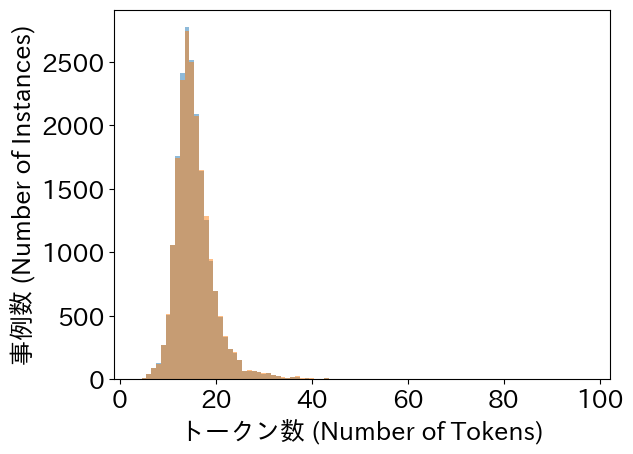

100%|██████████| 2434/2434 [00:01<00:00, 1439.52it/s]


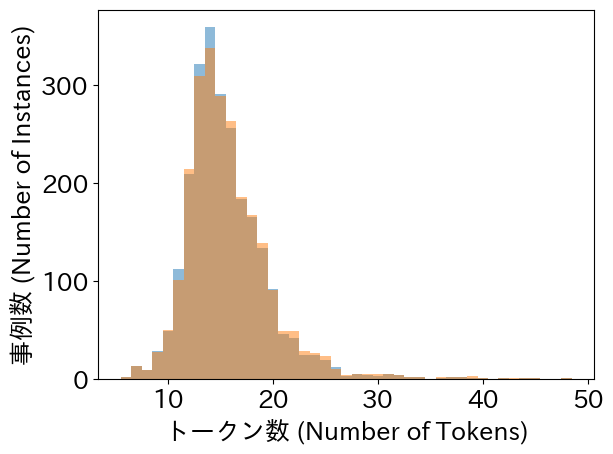

In [6]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18  # Increase the font size

def visualize_text_length(dataset: Dataset):
    """Draw a graph of the distribution of token counts in texts within the dataset"""
    # Count the lengths of texts in the dataset
    length_counter1 = Counter()
    length_counter2 = Counter()
    for data in tqdm(dataset):
        length1 = len(tokenizer.tokenize(data["sentence1"]))  # Tokenize and measure the length of sentence1
        length_counter1[length1] += 1
        length2 = len(tokenizer.tokenize(data["sentence2"]))  # Tokenize and measure the length of sentence2
        length_counter2[length2] += 1
    # Draw a bar graph from the values of length_counter
    plt.bar(length_counter1.keys(), length_counter1.values(), width=1.0, alpha=0.5)
    plt.bar(length_counter2.keys(), length_counter2.values(), width=1.0, alpha=0.5)
    plt.xlabel("トークン数 (Number of Tokens)")
    plt.ylabel("事例数 (Number of Instances)")
    plt.show()

visualize_text_length(train_dataset)
visualize_text_length(valid_dataset)

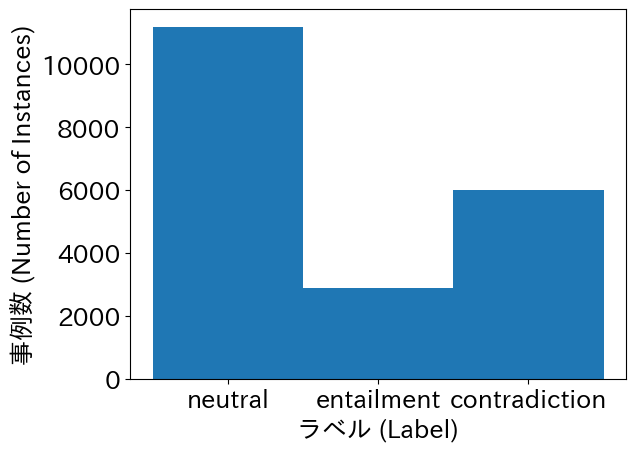

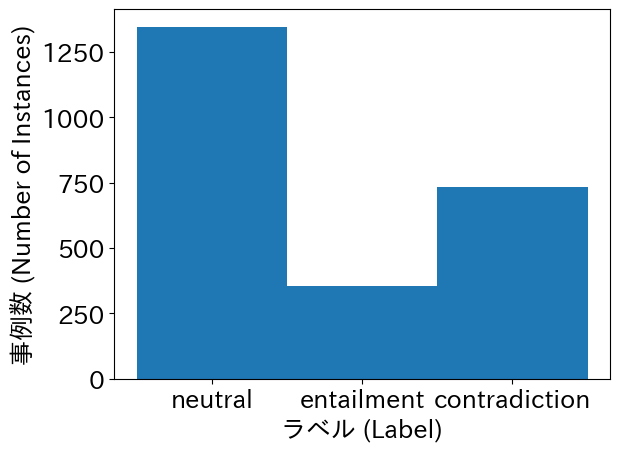

In [7]:
def visualize_labels(dataset: Dataset):
    """Draw a graph of the label distribution in the dataset"""
    # Count the number of labels in the dataset
    label_counter = Counter()
    for data in dataset:
        label_id = data["label"]
        label_name = dataset.features["label"].names[label_id]
        label_counter[label_name] += 1
    # Draw the label_counter as a bar graph
    plt.bar(label_counter.keys(), label_counter.values(), width=1.0)
    plt.xlabel("ラベル (Label)")
    plt.ylabel("事例数 (Number of Instances)")
    plt.show()

visualize_labels(train_dataset)
visualize_labels(valid_dataset)

#### Preprocessing the Dataset

In [8]:
from transformers import BatchEncoding

def preprocess_text_pair_classification(
    example: dict[str, str | int]
) -> BatchEncoding:
    """Tokenize and convert text pair relationship prediction examples to IDs"""
    # The output is a BatchEncoding object with "input_ids", "token_type_ids", and "attention_mask" as keys,
    # and list[int] as the value
    encoded_example = tokenizer(
        example["sentence1"], example["sentence2"], max_length=128
    )

    # Match the key name "labels" to the argument name expected by the BertForSequenceClassification model's forward method
    # used subsequently
    encoded_example["labels"] = example["label"]
    return encoded_example

In [9]:
encoded_train_dataset = train_dataset.map(
    preprocess_text_pair_classification,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text_pair_classification,
    remove_columns=valid_dataset.column_names,
)

Map:   0%|          | 0/20073 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Map:   0%|          | 0/2434 [00:00<?, ? examples/s]

In [10]:
print(encoded_train_dataset[0])

{'input_ids': [2, 14269, 464, 13341, 430, 27914, 16753, 3107, 500, 5538, 456, 422, 12995, 385, 3, 33, 680, 464, 13341, 430, 384, 16517, 13208, 3107, 500, 29887, 456, 422, 12995, 385, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 2}


#### Mini Batch Construction

In [11]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
batch_inputs = data_collator(encoded_train_dataset[0:4])
pprint({name: tensor.size() for name, tensor in batch_inputs.items()})

{'attention_mask': torch.Size([4, 31]),
 'input_ids': torch.Size([4, 31]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 31])}


#### Preparing the Model



In [13]:
from transformers import AutoModelForSequenceClassification

class_label = train_dataset.features["label"]
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=class_label.num_classes,
    label2id=label2id,  # Specify the correspondence from label names to IDs
    id2label=id2label,  # Specify the correspondence from IDs to label names
)
print(type(model).__name__)

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/447M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification


In [14]:
print(model.forward(**data_collator(encoded_train_dataset[0:4])))

SequenceClassifierOutput(loss=tensor(1.3709, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.5438, -0.6999, -0.6652],
        [ 0.5443, -0.6911, -0.6591],
        [ 0.5689, -0.7136, -0.6473],
        [ 0.5303, -0.7133, -0.6069]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


#### Training Execution

In [15]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_jnli",  # Folder to save results
    per_device_train_batch_size=32,  # Batch size during training
    per_device_eval_batch_size=32,  # Batch size during evaluation
    learning_rate=2e-5,  # Learning rate
    lr_scheduler_type="linear",  # Type of learning rate scheduler
    warmup_ratio=0.1,  # Specify the length of learning rate warmup
    num_train_epochs=3,  # Number of training epochs
    save_strategy="epoch",  # Checkpoint save timing
    logging_strategy="epoch",  # Logging timing
    evaluation_strategy="epoch",  # Timing of evaluation with the validation set
    load_best_model_at_end=True,  # Load the best model based on the development set after training
    metric_for_best_model="accuracy",  # Metric to determine the best model
    fp16=True,  # Enable automatic mixed precision computation
)

In [16]:
import numpy as np

def compute_accuracy(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """Calculate accuracy from predicted labels and true labels"""
    predictions, labels = eval_pred
    # predictions are the scores for each label
    # The index with the highest score is considered as the predicted label
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

In [17]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_accuracy,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.498300,0.294343,0.894412
2,0.215300,0.312933,0.900575
3,0.127900,0.329099,0.910435


TrainOutput(global_step=1884, training_loss=0.2804892513655806, metrics={'train_runtime': 277.57, 'train_samples_per_second': 216.951, 'train_steps_per_second': 6.787, 'total_flos': 1654243904915154.0, 'train_loss': 0.2804892513655806, 'epoch': 3.0})

#### Model Evaluation after Training

In [18]:
# Evaluate the model on the validation set
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

{'epoch': 3.0,
 'eval_accuracy': 0.9104354971240756,
 'eval_loss': 0.32909920811653137,
 'eval_runtime': 2.3149,
 'eval_samples_per_second': 1051.429,
 'eval_steps_per_second': 33.262}


#### Save the Model

Save Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive

drive.mount("drive")

In [ ]:
# Copy the saved model to the Google Drive folder
!mkdir -p drive/MyDrive/llm-book
!cp -r output_jnli drive/MyDrive/llm-book

Save on Hugging Face Hub

In [ ]:
from huggingface_hub import login

login()

# Repository name on Hugging Face Hub
# Replace "YOUR-ACCOUNT" with your own username
repo_name = "YOUR-ACCOUNT/bert-base-japanese-v3-jnli"
# Upload the tokenizer and model
tokenizer.push_to_hub(repo_name)
model.push_to_hub(repo_name)